**Indicazioni all'utilizzo**
1. Eseguire il notebook con GPU attiva
Per ottenere prestazioni adeguate, è fondamentale eseguire il notebook su una sessione con accelerazione GPU.
2. Variabile ```is_debug = True```: Se impostata su True, attiva stampe estese per il debug:
  - Mostra circa un centinaio di esempi di commenti/testi.
  - Visualizza tutti i grafici generati nel processo.
3. Variabile ```save = True```: Se attiva, salva automaticamente tutti i grafici generati in formato immagine (graph_name.png) nella directory corrente.
4. Nota sulla prima cella di installazione:
```
!pip install transformers_interpret
```
  - Questa installazione serve esclusivamente per la parte di explainability.
  - tale cella causare un errore che dipende dalle versione di ```numpy``` di cui necessita.
  - Dopo l'installazione è necessario riavviare la sessione
  - Se non si vuole visionare l'explainability commentare la cella.


In [4]:
!pip install transformers_interpret # causa un erroe per via della versione di numpy di cui necessita

In [5]:
# Flag to control debugging output and intermediate visualizations
is_debugging = False
# Flag to control saving generated plots
save = False

# Data Exploration

## Data loading and cleaning

In [6]:
# Import
import pandas as pd
import random

In [7]:
def random_items(df: pd.DataFrame, n: int = 3) -> None:
    """
    Print n random entries from a DataFrame, showing full_text, title, and text
    if available and not null/empty.

    Args:
        df (pd.DataFrame): The input DataFrame to sample from.
        n (int, optional): The number of random items to print. Defaults to 3.
    """
    if df.empty:
        print("DataFrame is empty.")
        return

    # Ensure we don't sample more rows than available
    sample_size = min(n, len(df))

    # Sample the DataFrame with a random state for reproducibility of the sample within a run
    sample_df = df.sample(n=sample_size, random_state=random.randint(0, sample_size))

    print(f"\nDisplaying {sample_size} random items:")
    print("=" * 60)

    for i, (_, row) in enumerate(sample_df.iterrows(), start=1):
        print(f"Item {i} ---")

        # Use .get() that provide None if the column doesn't exist
        full_text = row.get('full_text')
        title = row.get('title')
        text = row.get('text')

        # Check if the column value exists and is not null or empty after stripping whitespace
        if full_text is not None and pd.notnull(full_text) and str(full_text).strip():
            print(f"Full Text: {full_text}")
        if title is not None and pd.notnull(title) and str(title).strip():
            print(f"Title: {title}")
        if text is not None and pd.notnull(text) and str(text).strip():
            print(f"Text: {text}")

        print("-" * 60) # Separator between items
    print("=" * 60) # Footer separator

In [8]:
# Resource link
url=('https://raw.githubusercontent.com/FrancescoRomeo02/TeslaAnalysis/refs/heads/main/')

In [9]:
# posts dataframe
df_posts_url = url + 'tesla_elon_reputation_dataset_enhanced_posts_only.csv'
df_posts = pd.read_csv(df_posts_url)
if is_debugging:
  random_items(df_posts)

In [10]:
# comments dataframe
df_comments_url = url + 'tesla_elon_reputation_dataset_enhanced_comments_only.csv'
df_comments = pd.read_csv(df_comments_url)
if is_debugging:
  random_items(df_comments)

In [11]:
if is_debugging:
  print(f'DataFrame load compelted, Post loaded: {df_posts["type"].count()}, Comments loaded: {df_comments["type"].count()}.')
  # manual random df evaluation
  print("Visualiziamo 50 elementi random del dataframe posts:")
  random_items(df_posts, 50)
  print("Visualiziamo 50 elementi random del dataframe comments:")
  random_items(df_comments, 50)

### Eliminiazione di alcuni commenti sospetti e un user identificato come bot

In [12]:
target_string = "I am a bot, and this action was performed automatically."
# Filter out rows in 'df_comments' where the 'text' column contains the target_string.
df_comments = df_comments[~df_comments['text'].str.contains(target_string, na=False)].copy()

if is_debugging:
  print("Comments number after bot exclusion:", len(df_comments))

In [13]:
sus_user = "TeslaAI"
# Filter out rows in 'df_posts' where the 'author' is the suspected bot user.
df_posts = df_posts[df_posts['author'] != sus_user].copy()

if is_debugging:
  print("Posts number after sus user exclusion:", len(df_posts))

## Grafici

In [14]:
# Import
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [15]:
# define color palette
bar_plot = 'Blues'
sentiment_palette = 'RdYlGn'

### Bar Plot

In [16]:
def create_bar_plot(dataframe, title, xlabel, ylabel, x, y, hue=None, palette=bar_plot, scale=False, save=False, range=False) -> None:
    """
    Create a flexible bar plot using seaborn and matplotlib.

    Args:
        dataframe (pd.DataFrame): Data to plot.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        x (str): Column name for x-axis.
        y (str): Column name for y-axis.
        hue (str, optional): Column name for hue (e.g. categories). Default is None.
        palette (str): Seaborn color palette. Default is 'Blues'.
        scale (bool): If True, set y-axis to log scale.
        save (bool): If True, saves the figure as PNG using the title.
    """

    num_categories = dataframe[x].nunique()
    fig_width = max(10, num_categories * 0.6)
    plt.figure(figsize=(fig_width, 8))

    ax = sns.barplot(data=dataframe, x=x, y=y, hue=hue, palette=bar_plot if hue else None, legend=hue is not None)

    mean_value = dataframe[y].mean()
    plt.axhline(mean_value, color='red', linestyle=':', alpha=0.7,
                label=f"Mean = {mean_value:.2f}".rstrip('0').rstrip('.'))

    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    if range:
      plt.ylim(1, 5)

    if scale:
        plt.yscale('log')

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            formatted = f'{height:.2f}'.rstrip('0').rstrip('.') if isinstance(height, float) else str(height)
            ax.annotate(formatted,
                        (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=12,
                        xytext=(0, 0), textcoords='offset points')

    plt.legend()
    plt.tight_layout()

    if save:
        safe_title = title.lower().replace(' ', '_')
        plt.savefig(f"{safe_title}.png", dpi=300)

    plt.show()

In [17]:
# Use a copy to avoid warning
df_posts_cp = df_posts.copy()
df_comments_cp = df_comments.copy()

# Convert created_date to datetime
df_posts['created_date'] = pd.to_datetime(df_posts['created_date'])
df_posts['year'] = df_posts['created_date'].dt.year

df_comments['created_date'] = pd.to_datetime(df_comments['created_date'])
df_comments['year'] = df_comments['created_date'].dt.year

In [18]:
# Count posts and comments per year
posts_per_year = df_posts['year'].value_counts().sort_index()
comments_per_year = df_comments['year'].value_counts().sort_index()

# Convert to DataFrame for plotting
posts_per_year = pd.DataFrame({'year': posts_per_year.index, 'count': posts_per_year.values})
comments_per_year = pd.DataFrame({'year': comments_per_year.index, 'count': comments_per_year.values})

In [19]:
# show/ save "Number of posts per year" plot

if is_debugging:
  create_bar_plot(
      title='Number of posts per year',
      xlabel='Year',
      ylabel='Number of posts',
      dataframe=posts_per_year,
      x='year',
      y='count',
      hue='year',
      save = save
  )

In [20]:
# show/ save "Number of comments per year" plot

if is_debugging:
  create_bar_plot(
      title='Number of comments per year',
      xlabel='Year',
      ylabel='Number of comments',
      dataframe=comments_per_year,
      x='year',
      y='count',
      hue='year',
      save = save
  )

In [21]:
# Count the number of posts per subreddit
posts = df_posts.groupby('subreddit').size().rename('Posts')

# Count the number of comments per subreddit
comments = df_comments.groupby('subreddit').size().rename('Comments')

# Combine post and comment counts into a single DataFrame
counts = pd.concat([posts, comments], axis=1).fillna(0).astype(int).reset_index()

# Reshape the data for plotting: one row per subreddit-type pair
melted_counts = counts.melt(id_vars='subreddit', var_name='Type', value_name='Count')

# Rename column for consistency in plot labels
melted_counts.rename(columns={'subreddit': 'Subreddit'}, inplace=True)

In [22]:
# show/ save "Number of posts and comments per year" plot

if is_debugging:
  create_bar_plot(
      dataframe=melted_counts,
      title='Number of posts and comments per subreddit',
      xlabel='Subreddit',
      ylabel='Count',
      x='Subreddit',
      y='Count',
      hue='Type',
      save = save
  )

In [23]:
# Current subs for subreddits
subreddit_subscribers = {
    'teslamotors': 3400000,
    'TeslaLounge': 193000,
    'electricvehicles': 354000,
    'elonmusk': 2000000,
    'ElonMusketeers': 3100,
    'Musk': 3200,
    'technology': 19000000,
    'cars': 740000
}

In [24]:
def add_log_normalized_score(df, subreddit_subs):
    """
    Adds a new column 'score_log_norm' to the dataframe by normalizing the 'score'
    using the natural logarithm of the number of subreddit subscribers.

    Args:
        df (pd.DataFrame): The original dataframe with at least 'score' and 'subreddit'.
        subreddit_subs (dict): Dictionary mapping subreddit names to number of subscribers.

    Returns:
        pd.DataFrame: The dataframe with an additional 'score_log_norm' column.
    """
    df = df.copy()
    df['subscribers'] = df['subreddit'].map(subreddit_subs)
    df['score_log_norm'] = df['score'] / np.log1p(df['subscribers'])
    return df

In [25]:
# Apply log normalization to both posts and comments using the provided subreddit subscriber counts
df_posts_norm = add_log_normalized_score(df_posts, subreddit_subscribers)
df_comments_norm = add_log_normalized_score(df_comments, subreddit_subscribers)

# Create pivot tables to compute the mean log-normalized score for each subreddit (posts and comments separately)
heatmap_data_posts_norm = df_posts_norm.pivot_table(
    index='subreddit',
    values='score_log_norm',
    aggfunc='mean'
)

heatmap_data_comments_norm = df_comments_norm.pivot_table(
    index='subreddit',
    values='score_log_norm',
    aggfunc='mean'
)

In [26]:
# Add 'type' column to distinguish between posts and comments
df_posts_norm['type'] = 'Post'
df_comments_norm['type'] = 'Comment'

# Select only necessary columns for plotting
df_posts_plot = df_posts_norm[['subreddit', 'type', 'score_log_norm']]
df_comments_plot = df_comments_norm[['subreddit', 'type', 'score_log_norm']]

# Concatenate the post and comment DataFrames into a single DataFrame
combined_df = pd.concat([df_posts_plot, df_comments_plot], ignore_index=True)

# Group by subreddit and content type, then compute the average log-normalized score
df_grouped = combined_df.groupby(['subreddit', 'type'], as_index=False)['score_log_norm'].mean()

# Sort the results by normalized score in descending order for better visualization
df_grouped = df_grouped.sort_values('score_log_norm', ascending=False)

In [27]:
# show/ save "Log Normalized Score by Subreddit and Type" plot

if is_debugging:
  create_bar_plot(
      df_grouped,
      title='Log Normalized Score by Subreddit and Type',
      xlabel='Subreddit',
      ylabel='Log Normalized Score',
      x='subreddit',
      y='score_log_norm',
      hue='type',
      scale=True,
      save=save
  )

### Altri Plot

In [28]:
# Count occurrences of 'mention_type' in both posts and comments, and label each with its origin
posts_counts = (
    df_posts['mention_type']
    .value_counts()
    .rename_axis('Mention Type')
    .reset_index(name='Count')
)
posts_counts['Type'] = 'Posts'

comments_counts = (
    df_comments['mention_type']
    .value_counts()
    .rename_axis('Mention Type')
    .reset_index(name='Count')
)
comments_counts['Type'] = 'Comments'

# Combine the two DataFrames into a single one for comparative analysis
melted_mention_counts = pd.concat([posts_counts, comments_counts], ignore_index=True)

In [29]:
# show/ save "Counting by mention type" plot

if is_debugging:
  create_bar_plot(
      dataframe=melted_mention_counts,
      title='Counting by mention type',
      xlabel='Mention Type',
      ylabel='Count',
      x='Mention Type',
      y='Count',
      hue='Type',
  )

In [30]:
# Remove '[deleted]' authors from the original DataFrames
author_counts_posts = df_posts[df_posts['author'] != '[deleted]']['author'].value_counts()
author_counts_comments = df_comments[df_comments['author'] != '[deleted]']['author'].value_counts()

# Identify authors who appear more than once in both posts and comments
common_authors = author_counts_posts.index.intersection(author_counts_comments.index)
common_authors_filtered = [
    author for author in common_authors
    if author_counts_posts[author] > 1 and author_counts_comments[author] > 1
]

# Create a DataFrame with combined post and comment counts
combined_counts = pd.DataFrame({
    'Posts': author_counts_posts[common_authors_filtered],
    'Comments': author_counts_comments[common_authors_filtered]
})

# Add total activity (Posts + Comments) and sort to get top 3
combined_counts['Total'] = combined_counts['Posts'] + combined_counts['Comments']
top_3_authors = combined_counts.sort_values('Total', ascending=False).head(3)

# Debug output if enabled
if is_debugging:
    print("Top 3 authors (excluding '[deleted]') active in both posts and comments:")
    print(top_3_authors)

#### Eliminiamo le variabili non più necessarie per recuperare spazio

In [31]:
# Get the list of all variables of type DataFrame in the global scope
dfs = %who_ls DataFrame

# Define the DataFrames you want to keep
keep_dfs = ['df_posts', 'df_comments']

# Delete all DataFrames except the ones explicitly listed
for var in dfs:
    if var not in keep_dfs:
        print(f"Deleting {var}")
        del globals()[var]

# Confirm which DataFrames are still present
remaining_dfs = %who_ls DataFrame
print("\nRemaining DataFrames:", remaining_dfs)

Deleting combined_counts
Deleting combined_df
Deleting comments_counts
Deleting comments_per_year
Deleting counts
Deleting df_comments_cp
Deleting df_comments_norm
Deleting df_comments_plot
Deleting df_grouped
Deleting df_posts_cp
Deleting df_posts_norm
Deleting df_posts_plot
Deleting heatmap_data_comments_norm
Deleting heatmap_data_posts_norm
Deleting melted_counts
Deleting melted_mention_counts
Deleting posts_counts
Deleting posts_per_year
Deleting top_3_authors

Remaining DataFrames: ['df_comments', 'df_posts']


## Features Selection

In [32]:
import re

In [33]:
def find_most_frequent_keyword(text, keywords):
    """
    Identify the most frequently occurring keyword in a given text.

    Parameters:
    - text (str): The input text to search through.
    - keywords (list of str): A list of keywords to count in the text.

    Returns:
    - str: The keyword with the highest frequency based on exact matches.
    - np.nan: If the text is empty, invalid, or none of the keywords are found.

    Notes:
    - The function is case-insensitive.
    - Keywords are matched using word boundaries to avoid partial matches.
    - If multiple keywords have the same maximum frequency, the first in the list is returned.
    """
    if not isinstance(text, str) or not text.strip():
        return np.nan

    text = text.lower()

    # Count exact keyword matches using word boundaries
    counts = {
        kw: len(re.findall(rf'\b{re.escape(kw)}\b', text))
        for kw in keywords
    }

    max_count = max(counts.values())
    if max_count == 0:
        return np.nan

    # Return the first keyword with the highest count
    for kw in keywords:
        if counts[kw] == max_count:
            return kw

In [34]:
if is_debugging:
    # Print column names of posts and comments DataFrames for inspection
    print("Posts dataframe columns names:")
    print(df_posts.columns)

    print("=" * 60)

    print("Comments dataframe columns names:")
    print(df_comments.columns)

In [35]:
# Define the relevant columns to retain for posts and comments
columns_to_keep = [
    'type',
    'text',
    'title',
    'score',
    'subreddit',
    'created_date',
    'mention_type',
    'author'
]

# Create independent copies of the filtered data to avoid altering original DataFrames
posts_df = df_posts[columns_to_keep].copy()
comments_df = df_comments[columns_to_keep].copy()

In [36]:
# Clean and filter posts: remove rows with missing or empty titles
posts_df = posts_df.dropna(subset=['title'])
posts_df = posts_df[posts_df['title'].str.strip().astype(bool)]

# Clean and filter comments: remove rows with missing or empty texts
comments_df = comments_df[comments_df['text'].str.strip().astype(bool)]

In [37]:
# Clean and combine textual fields in posts
# Ensure 'title' and 'text' are strings with no NaN issues
posts_df['title'] = posts_df['title'].fillna('').astype(str).str.strip()
posts_df['text'] = posts_df['text'].fillna('').astype(str).str.strip()

# Combine 'title' and 'text' into a single 'full_text' column
posts_df['full_text'] = posts_df['title'] + posts_df['text'].apply(lambda t: f". {t}" if t else '')

# Ensure 'text' column is string with no NaN issues in comments_df
comments_df['text'] = comments_df['text'].fillna('').astype(str).str.strip()

# rename text into full_text
comments_df['full_text'] = comments_df['text']


# Select and reorder relevant columns
base_columns = ['type', 'author', 'subreddit', 'created_date', 'mention_type', 'score',]

# Final post and comment DataFrames
final_posts_df = posts_df[[*base_columns, 'full_text']].copy()
final_comments_df = comments_df[[*base_columns, 'full_text']].copy()


# Lista keywords già in lowercase
tesla_keywords = [
    'model s', 'model 3', 'model x', 'model y',
    'cybertruck', 'roadster', 'powerwall', 'solar panel',
    'autopilot', 'full self driving',
    'gigafactory', 'supercharger', 'tsla', 'neuralink'
]

# Apply on posts
final_posts_df['keyword'] = final_posts_df['full_text'].apply(lambda txt: find_most_frequent_keyword(txt, tesla_keywords))

# Apply on comments
final_comments_df['keyword'] = final_comments_df['full_text'].apply(lambda txt: find_most_frequent_keyword(txt, tesla_keywords))

# Display random samples if debugging is enabled
if is_debugging:
    print("\nSample of cleaned post data:")
    random_items(final_posts_df)

    print("\nSample of cleaned comment data:")
    random_items(final_comments_df)

# Sent. analysis

## Modello

In [38]:
from transformers import pipeline

# Initialize the sentiment analysis pipeline using a multilingual BERT model
# This pipeline analyzes text sentiment, outputting ratings (e.g., 1 to 5 stars).
# The 'truncation="only_first"' parameter ensures that if input text is too long,
# only the first part is truncated to fit the model's max input length.
sentiment_analyzer = pipeline(
    task="sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    truncation="only_first"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [39]:
# Extract texts from posts and comments
post_texts = final_posts_df['full_text'].tolist()
comment_texts = final_comments_df['full_text'].tolist()

# Perform sentiment analysis in batch
post_predictions = sentiment_analyzer(post_texts)
comment_predictions = sentiment_analyzer(comment_texts)

# Extract sentiment labels from model output
final_posts_df.loc[:, 'sentiment'] = [res['label'] for res in post_predictions]
final_comments_df.loc[:, 'sentiment'] = [res['label'] for res in comment_predictions]

In [40]:
if is_debugging:
  # Display sample results from posts
  print("Sample Post Sentiments:")
  # Sample 3 random posts for inspection. random_state ensures reproducibility of the sample.
  for _, row in final_posts_df.sample(3, random_state=42).iterrows():
      print(f"Full Text: {row['full_text']}")
      print(f"Predicted Sentiment: {row['sentiment']}")
      print("-" * 60)

  # Display sample results from comments
  print("\nSample Comment Sentiments:")
  # Sample 3 random comments for inspection.
  for _, row in final_comments_df.sample(3, random_state=42).iterrows():
      # Print the full text used for sentiment analysis.
      print(f"Text: {row['full_text']}") # Corrected column name
      print(f"Predicted Sentiment: {row['sentiment']}")
      print("-" * 60)

## Grafici

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [42]:
def get_period_range(end_date):
    """Returns the start and end dates of a resampling period given the end date."""
    try:
        # Try to get offset for the resampling period (e.g. 'M', 'W')
        offset = pd.tseries.frequencies.to_offset(resample_period)
    except ValueError:
        # Fallback to 1 month if resample_period is invalid
        offset = pd.offsets.MonthEnd(1)
    # Calculate start date by subtracting offset (period length) from end_date
    start_date = end_date - offset + pd.Timedelta(days=1)
    return pd.Timestamp(start_date), pd.Timestamp(end_date)

In [43]:

def print_texts(df_period, title, start, end, value=None, delta=False) -> None:
    """Print texts for a given period, with optional sentiment metrics."""
    # Format metric string as delta (Δ) or average (avg)
    metric = f"{'Δ = ' + str(round(value, 2)) if delta else 'avg: ' + str(round(value, 2))}" if value is not None else ''
    print(f"\n{title_prefix} in period with {title} ({start.date()} to {end.date()}) - {metric}")
    print("-" * 80)

    if df_period.empty:
        print("No content available in this period.")
    else:
        # Print each text content in the filtered period
        for _, row in df_period.iterrows():
            content = row.get(text_column, 'N/A')
            print(content)
            print("-" * 80)
    print("=" * 100)

In [44]:
def show_period(title, date, value, delta=False) -> None:
    """Helper to extract data for a specific period and print its texts and sentiment."""
    start, end = get_period_range(date)
    # Filter the global DataFrame for rows within the period
    df_period = df_copy[(df_copy['created_date'] >= start) & (df_copy['created_date'] <= end)]
    # Print filtered texts with sentiment info
    print_texts(df_period, title, start, end, value, delta=delta)

In [45]:
def text_sentiment_over_time(
    df: pd.DataFrame,
    title_prefix: str,
    text_column: str,
    resample_period: str = '2ME'
) -> None:
    """
    Analyzes sentiment evolution over time and prints the texts during periods of:
    - highest sentiment
    - lowest sentiment
    - largest sentiment change (delta from previous period)

    Parameters:
    - df (pd.DataFrame): DataFrame with 'created_date' and 'sentiment_score' columns
    - title_prefix (str): Label prefix for output titles (e.g., 'Comments', 'Posts')
    - text_column (str): Name of the text column to print
    - resample_period (str): Frequency string for resampling (e.g., 'ME', '2ME', 'Q', etc.)
    """
    df_copy = df.copy()
    df_copy['created_date'] = pd.to_datetime(df_copy['created_date'])

    # Resample sentiment scores by period (mean value)
    sentiment_resampled = (
        df_copy.set_index('created_date')['sentiment_score']
        .resample(resample_period)
        .mean()
    )

    # Highest sentiment
    if not sentiment_resampled.empty:
        max_date = sentiment_resampled.idxmax()
        show_period("HIGHEST sentiment", max_date, sentiment_resampled[max_date])
    else:
        print("\nNo resampled data to determine highest sentiment period.")

    # Lowest sentiment
    if not sentiment_resampled.empty:
        min_date = sentiment_resampled.idxmin()
        show_period("LOWEST sentiment", min_date, sentiment_resampled[min_date])
    else:
        print("\nNo resampled data to determine lowest sentiment period.")

    # Largest sentiment change (absolute delta from previous period)
    sentiment_diff = sentiment_resampled.diff().abs()
    if not sentiment_diff.empty and sentiment_diff.max() > 0:
        delta_date = sentiment_diff.idxmax()
        show_period("LARGEST sentiment change", delta_date, sentiment_diff[delta_date], delta=True)
    else:
        print("\nNo sufficient data or change to identify largest sentiment variation.")

In [46]:
def plot_sentiment_trend(df, title_prefix, resample_period, period_label, save=False) -> None:
    """
    Visualizes the trend of sentiment over time using a smoothed line plot.

    Parameters:
    - df (pd.DataFrame): Must contain 'created_date' and 'sentiment_score'.
    - title_prefix (str): Prefix used in the chart title (e.g., 'Posts', 'Comments').
    - resample_period (str): Frequency string for resampling (e.g., 'W', 'ME', '2ME').
    - period_label (str): Human-friendly period label (e.g., 'Weekly', 'Monthly').
    - save (bool): If True, saves the figure as a PNG file.
    """
    if df.empty:
        print("DataFrame is empty. Cannot plot sentiment trend.")
        return

    df['created_date'] = pd.to_datetime(df['created_date'], errors='coerce')
    df = df.dropna(subset=['created_date', 'sentiment_score'])

    # Resample sentiment time series
    sentiment_ts = (
        df.set_index('created_date')['sentiment_score']
        .resample(resample_period)
        .mean()
        .dropna()
    )

    if sentiment_ts.empty:
        print("Resampled sentiment data is empty. Cannot generate plot.")
        return

    # Compute basic statistics
    mean_sentiment = sentiment_ts.mean()
    std_sentiment = sentiment_ts.std()
    sentiment_diff = sentiment_ts.diff().abs()

    # Identify key points
    max_date, max_score = sentiment_ts.idxmax(), sentiment_ts.max()
    min_date, min_score = sentiment_ts.idxmin(), sentiment_ts.min()
    max_change_date, max_change_value = sentiment_diff.idxmax(), sentiment_diff.max()

    # Summary (console output)
    print(f"\nPeak Sentiment:    {max_date.date()} → {max_score:.2f}")
    print(f"Lowest Sentiment:  {min_date.date()} → {min_score:.2f}")
    print(f"Largest Change:    {max_change_date.date()} → Δ = {max_change_value:.2f}")

    # Plot setup
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(13, 6))

    # Plot line
    sns.lineplot(x=sentiment_ts.index, y=sentiment_ts.values,
                 color="#1f77b4", linewidth=2.5, label='Avg. Sentiment', ax=ax)

    # Annotate key points
    ax.axhline(mean_sentiment, color='red', linestyle='--',
               label=f"Mean = {mean_sentiment:.2f} ± {std_sentiment:.2f}")
    ax.plot(max_date, max_score, 'go', markersize=8, label=f"Peak = {max_score:.2f}")
    ax.plot(min_date, min_score, 'ro', markersize=8, label=f"Trough = {min_score:.2f}")

    # Formatting
    ax.set_ylim(1, 5)
    ax.set_title(f"{title_prefix} – Sentiment Trend ({period_label})", fontsize=16)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Average Sentiment", fontsize=12)
    ax.tick_params(axis='x', rotation=30)
    ax.legend()
    ax.grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()

    # Save plot if requested
    if save:
        filename = f"{title_prefix.lower().replace(' ', '_')}_sentiment_trend_{period_label.lower()}.png"
        plt.savefig(filename, dpi=300)
        print(f"Plot saved as {filename}")

    plt.show()

In [47]:
def plot_sentiment_by_mention_type(df, title_prefix, period, period_name):
    """
    Plot the evolution of average sentiment scores over time for different mention types.

    Shows the first and last sentiment value in the timeline for each mention type.
    """
    df = df.copy()
    df['created_date'] = pd.to_datetime(df['created_date'])

    color_map = {
        'elon': '#03045e',
        'tesla': '#00b4d8',
        'both': '#1f77b4'
    }
    linestyles = {
        'elon': '-',
        'tesla': '-',
        'both': ':'
    }

    plt.figure(figsize=(12, 6))

    for mention in ['elon', 'tesla', 'both']:
        df_mention = df[df['mention_type'] == mention]
        if df_mention.empty:
            print(f"No data for mention type: '{mention}'")
            continue

        sentiment_over_time = (
            df_mention
            .set_index('created_date')['sentiment_score']
            .resample(period)
            .mean()
            .dropna()
        )

        if sentiment_over_time.empty:
            continue

        start_date = sentiment_over_time.index[0]
        start_value = sentiment_over_time.iloc[0]
        end_date = sentiment_over_time.index[-1]
        end_value = sentiment_over_time.iloc[-1]

        plt.plot(
            sentiment_over_time.index,
            sentiment_over_time.values,
            label=f'{mention.capitalize()}',
            color=color_map[mention],
            linestyle=linestyles[mention],
            linewidth=2.0
        )

        # Annotate start and end points
        plt.scatter([start_date, end_date], [start_value, end_value], color=color_map[mention], s=60, zorder=5)
        plt.text(start_date, start_value - 0.2, f'{start_value:.2f}', color=color_map[mention],
                 ha='center', fontsize=12)
        plt.text(end_date, end_value - 0.2, f'{end_value:.2f}', color=color_map[mention],
                 ha='center', fontsize=12)

    plt.title(f'{title_prefix} Sentiment Evolution Over Time by Topic ({period_name})')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.ylim(1, 5)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Mention Type')
    plt.tight_layout()
    plt.show()

In [48]:
# Define sentiment-to-score mapping
sentiment_to_score = {
    '1 star': 1,
    '2 stars': 2,
    '3 stars': 3,
    '4 stars': 4,
    '5 stars': 5
}

# Map sentiment labels to numeric scores for posts and comments
final_posts_df['sentiment_score'] = final_posts_df['sentiment'].map(sentiment_to_score)
final_comments_df['sentiment_score'] = final_comments_df['sentiment'].map(sentiment_to_score)

# Save the df
if save:
  final_posts_df.to_csv('final_posts_df.csv', index=False)
  final_comments_df.to_csv('final_comments_df.csv', index=False)

In [49]:
if is_debugging:
  plot_sentiment_trend(final_posts_df, 'Posts', 'ME', 'Mothly')

In [50]:
if is_debugging:
  plot_sentiment_trend(final_comments_df, 'Comments', 'ME', 'Mothly')

In [51]:
if is_debugging:
  text_sentiment_over_time(final_posts_df, 'Posts', 'full_text', resample_period='2ME')

In [52]:
if is_debugging:
  text_sentiment_over_time(final_comments_df, 'Comments', 'full_text', resample_period='2ME')

In [53]:
combined_df = pd.concat([final_posts_df, final_comments_df], ignore_index=True)

In [54]:
if is_debugging:
  plot_sentiment_trend(combined_df, 'Posts & Comments', 'ME', 'Mothly')

In [55]:
if is_debugging:
  text_sentiment_over_time(combined_df, 'Posts & Comments', 'full_text', resample_period='2ME')

In [56]:
# Extract year from 'created_date' for both DataFrames
final_posts_df['year'] = pd.to_datetime(final_posts_df['created_date']).dt.year
final_comments_df['year'] = pd.to_datetime(final_comments_df['created_date']).dt.year

# Compute average sentiment per year
sentiment_per_year_posts = (
    final_posts_df.groupby('year')['sentiment_score'].mean().reset_index()
)
sentiment_per_year_comments = (
    final_comments_df.groupby('year')['sentiment_score'].mean().reset_index()
)

# Merge yearly sentiment scores on 'year'
sentiment_per_year_combined = pd.merge(
    sentiment_per_year_posts,
    sentiment_per_year_comments,
    on='year',
    suffixes=('_posts', '_comments')
)

# Compute correlation matrix between posts and comments sentiment
correlation_matrix = sentiment_per_year_combined[
    ['sentiment_score_posts', 'sentiment_score_comments']
].corr()

# Rename for visual clarity
correlation_matrix.index = ['Posts', 'Comments']
correlation_matrix.columns = ['Posts', 'Comments']

In [57]:
if is_debugging:
  # Plot heatmap of yearly sentiment correlation between posts and comments
  plt.figure(figsize=(6, 5))
  sns.set_style("white")

  sns.heatmap(
      correlation_matrix,
      annot=True,
      cmap=bar_plot,
      fmt=".2f",
      linewidths=0.5,
      vmin=0.5, vmax=1,
      square=True,
      cbar_kws={"shrink": 0.8}
  )

  plt.title("Yearly Average Sentiment Correlation\nPosts vs Comments", fontsize=12, pad=15)
  plt.xticks(rotation=0)
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.show()

In [58]:
# 'created_date' as datetime and extract the year
combined_df['created_date'] = pd.to_datetime(combined_df['created_date'])
combined_df['year'] = combined_df['created_date'].dt.year

# Group by sentiment score and year, count occurrences
heatmap_data = combined_df.groupby(['sentiment_score', 'year']).size().unstack(fill_value=0)

# Sort sentiment scores in ascending order
heatmap_data = heatmap_data.sort_index()

# Normalize each column to get the percentage distribution per year
heatmap_normalized = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)

if is_debugging:
  # Plot heatmap
  plt.figure(figsize=(12, 8))
  sns.set_style("white")
  sns.heatmap(
      heatmap_normalized,
      annot=True,
      fmt='.2%',
      cmap=bar_plot,
      linewidths=0.5,
      cbar_kws={"shrink": 0.8}
  )
  plt.title('Percentage Distribution of Sentiment by Year (Posts + Comments)', fontsize=13, pad=15)
  plt.ylabel('Sentiment')
  plt.xlabel('Year')
  plt.yticks(rotation=0)
  plt.xticks(rotation=0)
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

In [59]:
# Calculate average sentiment score per subreddit and sort ascending
subreddit_sentiment = combined_df.groupby('subreddit')['sentiment_score'].mean().sort_values()

# Convert Series to DataFrame and rename columns appropriately
subreddit_sentiment_df = subreddit_sentiment.reset_index()
subreddit_sentiment_df.columns = ['subreddit', 'sentiment_score']

if is_debugging:
  # Generate the bar plot with the provided parameters
  create_bar_plot(
      dataframe=subreddit_sentiment_df,
      title='Average Sentiment Score per Subreddit',
      xlabel='Subreddit',
      ylabel='Average Sentiment Score',
      x='subreddit',
      y='sentiment_score',
      hue='subreddit',
      save=save,
      range=True
  )

In [60]:
# Ensure 'created_date' column is datetime type and extract the year as numeric
combined_df['created_date'] = pd.to_datetime(combined_df['created_date'])
combined_df['year'] = combined_df['created_date'].dt.year
combined_df['year'] = pd.to_numeric(combined_df['year'], errors='coerce')

# Count number of comments per subreddit and year
comment_counts = (
    combined_df
    .groupby(['subreddit', 'year'])
    .size()
    .reset_index(name='comment_count')
)

# Count total number of comments per year across all subreddits
total_counts_per_year = (
    combined_df
    .groupby('year')
    .size()
    .reset_index(name='total_comments')
)

# Merge total annual comment counts with subreddit-year comment counts
comment_counts = comment_counts.merge(total_counts_per_year, on='year')

# Calculate percentage of comments contributed by each subreddit per year
comment_counts['comment_percentage'] = (
    comment_counts['comment_count'] / comment_counts['total_comments']
) * 100

# Compute average sentiment score per subreddit per year
sentiment_means = (
    combined_df
    .groupby(['subreddit', 'year'])['sentiment_score']
    .mean()
    .reset_index()
    .rename(columns={'sentiment_score': 'avg_annual_sentiment'})
)

# Merge average sentiment with comment percentages on subreddit and year
final_result = sentiment_means.merge(
    comment_counts[['subreddit', 'year', 'comment_percentage']],
    on=['subreddit', 'year']
)

In [61]:
if is_debugging:
  # Create figure and axes
  fig, ax = plt.subplots(figsize=(14, 8))

  # Bubble chart using Seaborn scatterplot
  scatter = sns.scatterplot(
      data=final_result,
      x='year',
      y='subreddit',
      size='comment_percentage',
      hue='avg_annual_sentiment',
      sizes=(50, 1200),
      palette=sentiment_palette,
      alpha=0.7,
      edgecolor='black',
      ax=ax
  )

  # Manual normalization for the colorbar
  norm = mpl.colors.Normalize(vmin=1, vmax=5)
  sm = plt.cm.ScalarMappable(cmap=sentiment_palette, norm=norm)
  sm.set_array([])  # Required for colorbar creation

  # Add colorbar linked to the scatter plot on the specified axes
  cbar = plt.colorbar(sm, ax=ax)
  cbar.set_label("Average Sentiment")

  # Aesthetics and labels
  ax.set_title("Bubble Chart: Average Sentiment by Subreddit and Year", fontsize=14)
  ax.set_xlabel("Year")
  ax.set_ylabel("Subreddit")
  ax.invert_yaxis()
  ax.legend_.remove()
  plt.tight_layout()
  plt.show()

In [62]:
# Calculate average sentiment score grouped by mention type and sort the values
mention_sentiment = combined_df.groupby('mention_type')['sentiment_score'].mean().sort_values()

# Convert the Series to a DataFrame and rename columns for clarity
mention_sentiment_df = mention_sentiment.reset_index()
mention_sentiment_df.columns = ['mention_type', 'sentiment_score']

if is_debugging:
  # Generate a bar plot showing average sentiment score per mention type
  create_bar_plot(
      dataframe=mention_sentiment_df,
      title='Average Sentiment Score by Topic',
      xlabel='Topic',
      ylabel='Average Sentiment Score',
      x='mention_type',
      y='sentiment_score',
      hue='mention_type',
      save=True,
      range=True
  )

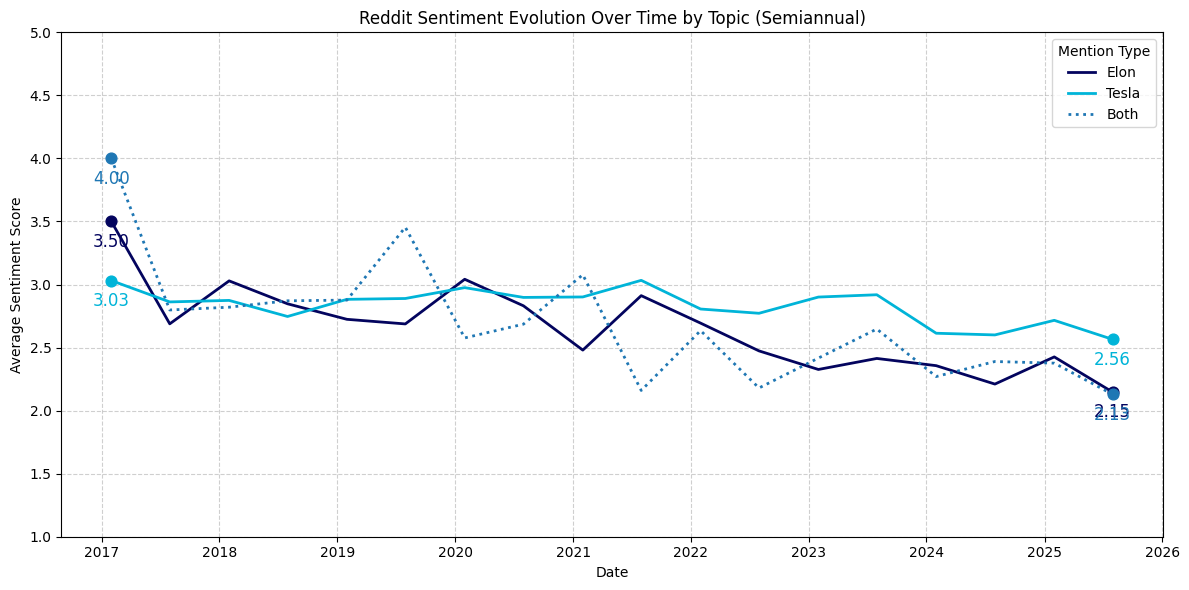

In [63]:
plot_sentiment_by_mention_type(
    df=combined_df,
    title_prefix='Reddit',
    period='6ME',
    period_name='Semiannual'
)

In [64]:
# Filter and resample sentiment scores for each mention type (semiannual)
tesla_sentiment = (
    combined_df[combined_df['mention_type'] == 'tesla']
    .set_index('created_date')['sentiment_score']
    .resample('6ME')
    .mean()
)

elon_sentiment = (
    combined_df[combined_df['mention_type'] == 'elon']
    .set_index('created_date')['sentiment_score']
    .resample('6ME')
    .mean()
)

# Combine both series with aligned dates (drop periods where one is missing)
combined = pd.concat([tesla_sentiment, elon_sentiment], axis=1, keys=['tesla', 'elon']).dropna()

# Compute Pearson correlation coefficient
correlation = combined['tesla'].corr(combined['elon'])

print(f"\nCorrelation between Tesla and Elon sentiment (semiannual): {correlation:.2f}")


Correlation between Tesla and Elon sentiment (semiannual): 0.72


In [65]:
# Remove rows without 'keyword' (filtering for Tesla keywords assumed)
df_kw = combined_df.dropna(subset=['keyword']).copy()

# Ensure 'year' column is numeric and drop rows with invalid years
df_kw['year'] = pd.to_numeric(df_kw['year'], errors='coerce')
df_kw = df_kw.dropna(subset=['year'])

# Count comments per keyword and year
comment_counts = (
    df_kw
    .groupby(['keyword', 'year'])
    .size()
    .reset_index(name='comment_count')
)

# Count total comments per year
total_counts_per_year = (
    df_kw
    .groupby('year')
    .size()
    .reset_index(name='total_comments')
)

# Merge to associate total annual comments with each keyword-year group
comment_counts = comment_counts.merge(total_counts_per_year, on='year')

# Calculate comment percentage per keyword/year
comment_counts['comment_percentage'] = (
    comment_counts['comment_count'] / comment_counts['total_comments']
) * 100

# Calculate average sentiment per keyword/year
sentiment_means = (
    df_kw
    .groupby(['keyword', 'year'])['sentiment_score']
    .mean()
    .reset_index()
    .rename(columns={'sentiment_score': 'media_sentiment_annuale'})
)

# Final merge of sentiment means and comment percentages
risultato_finale = sentiment_means.merge(
    comment_counts[['keyword', 'year', 'comment_percentage']],
    on=['keyword', 'year']
)

In [66]:
# Copy dataframe to avoid modifying original
scatter_data = risultato_finale.copy()

# Normalize sizes for seaborn scatterplot (scale between min_size and max_size)
min_size, max_size = 50, 1200
sizes = scatter_data['comment_percentage']
sizes_norm = (sizes - sizes.min()) / (sizes.max() - sizes.min())
scatter_data['size_norm'] = sizes_norm * (max_size - min_size) + min_size

# Sort dataframe by comment_percentage ascending (smallest at top)
scatter_data = scatter_data.sort_values(by='comment_percentage', ascending=True)

# Set 'keyword' as ordered categorical according to sorted order
scatter_data['keyword'] = pd.Categorical(scatter_data['keyword'],
                                         categories=scatter_data['keyword'].unique(),
                                         ordered=True)

if is_debugging:
  # Create figure and axes
  fig, ax = plt.subplots(figsize=(14, 9))

  # Seaborn scatterplot
  scatter = sns.scatterplot(
      data=scatter_data,
      x='year',
      y='keyword',
      size='size_norm',
      hue='media_sentiment_annuale',
      palette=sentiment_palette,
      sizes=(min_size, max_size),
      alpha=0.7,
      edgecolor='black',
      ax=ax,
      legend=False
  )

  # Manual normalization and colorbar mapping
  norm = mpl.colors.Normalize(vmin=1, vmax=5)
  sm = plt.cm.ScalarMappable(cmap=sentiment_palette, norm=norm)
  sm.set_array([])

  # Attach colorbar to the axes
  cbar = plt.colorbar(sm, ax=ax)
  cbar.set_label('Average Sentiment (1-5)')

  # Plot aesthetics
  ax.set_title("Bubble Chart: Tesla Keyword Sentiment by Year (Seaborn)", fontsize=14)
  ax.set_xlabel("Year")
  ax.set_ylabel("Keyword")
  ax.invert_yaxis()
  ax.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  plt.show()

In [67]:
# Filter combined DataFrame for specific authors
authors_to_plot = ['chrisdh79', 'twinbee', 'cookingboy']
df_authors = combined_df[combined_df['author'].isin(authors_to_plot)].copy()

# Color mapping for authors
color_map = {
    'chrisdh79': '#03045e',
    'twinbee': '#00b4d8',
    'cookingboy': '#1f77b4'
}

# Ensure 'created_date' is datetime and extract 'year'
df_authors['created_date'] = pd.to_datetime(df_authors['created_date'])
df_authors['year'] = df_authors['created_date'].dt.year

# Group by author and year, calculate average sentiment
sentiment_by_author_year = (
    df_authors
    .groupby(['author', 'year'])['sentiment_score']
    .mean()
    .reset_index()
)

if is_debugging:
  # Plot line chart for each author
  plt.figure(figsize=(12, 7))

  for author in authors_to_plot:
      data = sentiment_by_author_year[sentiment_by_author_year['author'] == author]
      plt.plot(
          data['year'],
          data['sentiment_score'],
          label=author,
          color=color_map[author],
          marker='o',
          linewidth=2.0
      )

  plt.title('Sentiment Evolution Over Time by Authors')
  plt.xlabel('Year')
  plt.ylabel('Average Sentiment')
  plt.ylim(1, 5)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.legend(title='Author')
  plt.tight_layout()
  plt.show()

## Explainability

In [68]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import MultiLabelClassificationExplainer

In [69]:
# Load the tokenizer optimized for fast tokenization from the pretrained multilingual BERT sentiment model
tokenizer = AutoTokenizer.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment",
    use_fast=True
)

# Load the pretrained BERT model fine-tuned for sequence classification (sentiment analysis)
model = AutoModelForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment"
)

explainer = MultiLabelClassificationExplainer( model, tokenizer)

In [70]:
# Filter rows where 'testo_completo' has fewer than 20 words
df_filtrato = combined_df[combined_df['full_text'].str.split().str.len() < 20]

# Sample 3 random rows
riga_casuale = df_filtrato.sample(n=1)
riga_casuale2 = df_filtrato.sample(n=1)
riga_casuale3 = df_filtrato.sample(n=1)

# Print text + sentiment for each sampled row, ensuring conversion to string
print(
    str(riga_casuale['full_text'].values[0]) + ' ' + str(riga_casuale['sentiment'].values[0]) + '\n' +
    str(riga_casuale2['full_text'].values[0]) + ' ' + str(riga_casuale2['sentiment'].values[0]) + '\n' +
    str(riga_casuale3['full_text'].values[0]) + ' ' + str(riga_casuale3['sentiment'].values[0])
)

New Tesla Autopilot Attention Study: Interesting, Not Surprising 3 stars
Billionaires not paying taxes means poor and middle class Americans have to pay more in taxes.  Boycott Tesla. 1 star
Can you blame people for looking at that page and thinking the car can drive itself? 1 star


In [71]:
word_attributions = explainer(text=riga_casuale['full_text'].values[0])
_ = explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.15),1 star,-0.90,"[CLS] new tesla auto ##pil ##ot attention study : interesting , not sur ##pris ##ing [SEP]"
n/a,(0.46),2 stars,-0.22,"[CLS] new tesla auto ##pil ##ot attention study : interesting , not sur ##pris ##ing [SEP]"
n/a,(0.83),3 stars,1.72,"[CLS] new tesla auto ##pil ##ot attention study : interesting , not sur ##pris ##ing [SEP]"
n/a,(0.79),4 stars,1.07,"[CLS] new tesla auto ##pil ##ot attention study : interesting , not sur ##pris ##ing [SEP]"
n/a,(0.31),5 stars,-0.55,"[CLS] new tesla auto ##pil ##ot attention study : interesting , not sur ##pris ##ing [SEP]"


In [72]:
word_attributions = explainer(text=riga_casuale2['full_text'].values[0])
_ = explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.95),1 star,3.06,[CLS] billion ##aires not paying taxes means poor and middle class americans have to pay more in taxes . boy ##cott tesla . [SEP]
n/a,(0.83),2 stars,2.23,[CLS] billion ##aires not paying taxes means poor and middle class americans have to pay more in taxes . boy ##cott tesla . [SEP]
n/a,(0.53),3 stars,-0.63,[CLS] billion ##aires not paying taxes means poor and middle class americans have to pay more in taxes . boy ##cott tesla . [SEP]
n/a,(0.15),4 stars,-2.69,[CLS] billion ##aires not paying taxes means poor and middle class americans have to pay more in taxes . boy ##cott tesla . [SEP]
n/a,(0.10),5 stars,-2.50,[CLS] billion ##aires not paying taxes means poor and middle class americans have to pay more in taxes . boy ##cott tesla . [SEP]


In [73]:
word_attributions = explainer(text=riga_casuale3['full_text'].values[0])
_ = explainer.visualize()

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
n/a,(0.68),1 star,1.56,[CLS] can you blame people for looking at that page and thinking the car can drive itself ? [SEP]
n/a,(0.58),2 stars,0.47,[CLS] can you blame people for looking at that page and thinking the car can drive itself ? [SEP]
n/a,(0.52),3 stars,-0.88,[CLS] can you blame people for looking at that page and thinking the car can drive itself ? [SEP]
n/a,(0.40),4 stars,-1.33,[CLS] can you blame people for looking at that page and thinking the car can drive itself ? [SEP]
n/a,(0.31),5 stars,-0.92,[CLS] can you blame people for looking at that page and thinking the car can drive itself ? [SEP]
